### Energetics

The energetics of the system should be conserved over time

$$ E = \int \left( \frac{\phi |\textbf{u}|^2}{2} + \frac{\phi^2}{2} \right) \text{d}A $$

For conservation, $ \frac{dE}{dt} = 0 $.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf

from endgame_analysis import get_var, get_meta
import endgame_analysis  as eg

## useful constants
oneday = 86400.00
rearth = 6371220.00
twoomega = 1.4584e-4
gravity = 9.80616

In [29]:
import matplotlib

fna = 12   # adjust this if needs be
myfonta = 'Myriad Pro'
# myfonta = ‘Calibri’     uncomment this if you don’t have Myriad Pro
fonta = {'family' : myfonta,  
         'weight' : 'normal',
         'style'  : 'normal',
         'size'   : fna}
matplotlib.rc('font', **fonta)

## some useful functions
import os

def best_fit(xs, ys):
    """Using the method of least squares, return the gradient
    and y-intercept of the line of best fit through xs and ys."""
    A = np.array([xs, np.ones(len(xs))])
    return np.linalg.lstsq(A.T,ys)[0]

RESAVE_ALL_IMAGES = False
def save_chart(filename, overwrite=False):
    name = filename.split('.')
    if len(name) >= 2:
        ext = name[-1]
    else:
        ext = 'pdf'
        filename = filename+'.pdf'
    if (os.path.isfile('../images/'+filename) and overwrite is False) or (RESAVE_ALL_IMAGES is True):
        print('save_chart: not overwriting existing file') 
        return
    plt.tight_layout()
    plt.savefig('../images/'+filename, dpi=300, format=ext)
    print('save_chart: image saved to images/'+filename)
matplotlib.get_cachedir()

u'/home/links/jp492/.cache/matplotlib'

In [3]:
cur_file = 'data/run_data_20150707_114748.nc'  # gaussian sink profile
no_forcing_file = 'data/run_data_20150728_140709.nc'
cur_file = no_forcing_file
phi_dims, phi = get_var('phi', cur_file)
u_dims, u = get_var('u', cur_file)
v_dims, v = get_var('v', cur_file) 

times, lons, lats = phi_dims
dx = 2*np.pi / len(lons)
dy = np.pi / len(lats)

* $u$ is defined on the centre of vertical edges.
* $v$ is defined on the centre of horizontal edges.
* $\phi$ is defined at cell centres.

Shift all values to cell centres:

$$ 
\begin{align}
    \bar u_{i,j} = \frac{u_{i-\frac12, j} + u_{i+\frac12, j}}{2}\\
    \bar v_{i,j} = \frac{v_{i,j-\frac12} + v_{i,j+\frac12}}{2} 
\end{align}
$$


In [4]:
u_bar = (u + np.roll(u, 1, axis=1)) / 2.0      # roll around the longitudes
v_bar = v_bar = (v[:,:,1:] + v[:,:,:-1])/2.0   # contract the extra point in the lons

u_mod2 = u_bar**2 + v_bar**2
phi2 = phi**2


In [5]:
e = phi*u_mod2/2.0 + phi2/2
e.shape

(2401, 320, 160)

In [6]:
dA = np.cos(lats)*dx*dy

In [7]:
# sum over the entire domain at each timestep
# area dA of each cell is proportional to cos(lat)
E = (e*dA[np.newaxis,np.newaxis,:]).sum((1,2))
E.shape

(2401,)

(64650, 64660)

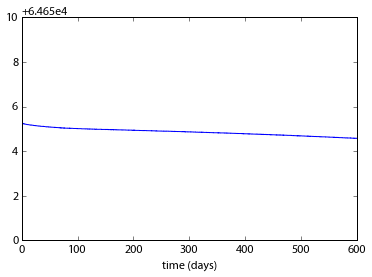

In [19]:
plt.plot(times/86400, E)
plt.xlabel('time (days)')
plt.ylim((64650, 64660))

Consider the size of the terms in the energetics function, $\phi^2$ is much much larger than $u$, dominant term.

In [42]:
np.max(phi2) / np.max(phi*u_mod2)

10895.81

Try instead the *available energy*, that is the deviation in geopotential surface from the mean

$$ \frac{\phi^2}{2} \to \frac{(\phi - \bar \phi)^2}{2} $$


In [16]:
phi_bar = phi.mean((1,2))  # temporal mean
avail_phi = phi - phi_bar[:, np.newaxis, np.newaxis]

save_chart: not overwriting existing file


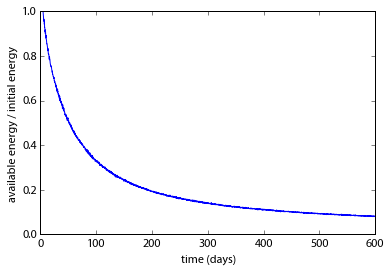

In [36]:
plt.figure(figsize=(6,4))
e_avail = (avail_phi*u_mod2 + avail_phi**2)/2
E_avail = (e_avail*dA[np.newaxis,np.newaxis,:]).sum((1,2))
plt.plot(times/oneday,E_avail/E_avail[1])
plt.xlabel('time (days)')
plt.ylabel('available energy / initial energy')
plt.ylim((0,1))
save_chart('energetics')

The chart shows that the total energy in the system approaches a steady state as time progresses.
This chart looks very similar to the total mass of the system, due to the dominance of the $\phi^2$ term.

Comparison of terms still suggests that available energy is the dominant term, but orders of magnitude less so:

In [47]:
np.max(avail_phi**2) / np.max(avail_phi*u_mod2)

253.70525

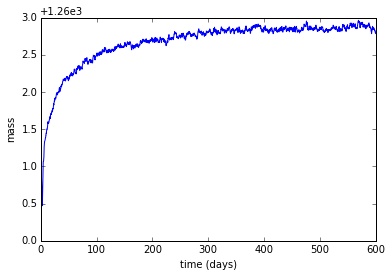

In [79]:
mass = (dA[np.newaxis,np.newaxis]*phi).sum((1,2))
plt.plot(times/oneday, mass)
plt.xlabel('time (days)')
plt.ylabel('mass')